# Metrics for ranking V<sub>H</sub>H enrichments (`fig-suppl-hts-metrics`)

In [1]:
import os

# change working directory to `./panning-massive` for simplicity of access to feature tables, etc
# make sure we don't do this twice, or we'll end up in the wrong place and be very confused
if 'dir_changed' not in globals():
    os.chdir('../../')
    dir_changed = True

In [2]:
from importlib import reload

import os.path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotnine
from plotnine import *
import altair as alt

In [3]:
import nbseq
import nbseq.ft
import nbseq.select as nbselect

In [4]:
# setup matplotlib to render figures as SVG with editable text preserved at appropriate font size
FONT_SIZE = 5

plt.rcParams.update({
    "font.family":"sans",
    "font.size": FONT_SIZE,
    "svg.fonttype": "none"
})

In [5]:
%config InlineBackend.figure_formats = ['svg']

***

In [6]:
ex = nbseq.Experiment.from_files(ft_aa=None,
                                 tree_cdr3=None, tree_aa=None) #'intermediate/cdr3/features/all/alpaca/asvs.nwk')
ex.fts.cdr3.obs['OprOP'] = np.nan

Loading experiment panning-massive from '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive'...
- Reading metadata from config/metadata_full.csv ...
- Reading phenotypes from config/phenotypes.csv ...
- Reading Config from config/config.yaml ...
- Warning: sqlite database '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive/intermediate/aa/asvs.db' does not exist
- Reading feature data for table 'cdr3' from results/tables/cdr3/asvs.csv (3.8 MB)...
- Reading cdr3 feature table from results/tables/cdr3/feature_table.biom (29.0 MB)...
- Warning: mmseqs2 database for space 'aa' at 'intermediate/aa/features_db/features' does not exist!
- Warning: mmseqs2 database for space 'cdr3' at 'intermediate/cdr3/features_db/features' does not exist!
- Reading enrichment model (conditional ECDF) for space cdr3 from results/tables/cdr3/enrichment/null/ecdf.pickle (307.6 kB)...
Finished in 0.71 seconds


In [7]:
ex

Experiment('panning-massive') with feature spaces ['cdr3']:
  obs: ['plate' 'well' 'depth' 'expt' 'round' 'sample' 'phage_library' 'notes'
    'r' 'io' 'kind' 'selection' 'replicate' 'name_full' 'name' 'well_027e'
    'sel_plate' 'sel_well' 'category' 'antigen' 'genotype_pair' 'gene_CS'
    'gene_S' 'genotype_CS' 'background_CS' 'strain_CS' 'loc_CS' 'cond_CS'
    'genotype_S' 'background_S' 'strain_S' 'loc_S' 'cond_S' 'cond_notes'  'bflm'
    'swim' 'twitch' 'swarm' 'PMB-R' 'FEP-R' 'TET-R' 'CIP-R' 'CHL-R'  'GEN-R'
    'ERY-R' 'IPM-R' 'cdiGMP' 'FliC' 'FliCa' 'FliCb' 'FlgEHKL' 'PilQ'  'PilA'
    'PilB' 'LasA' 'LasB' 'Apr' 'XcpQ' 'ToxA' 'EstA' 'LepA' 'PlpD'  'Phz' 'Pcn'
    'Pvd' 'Hcn' 'Rhl' 'T3SS' 'T6SS' 'Pel' 'Psl' 'CdrB' 'SCV'  'Mucoid'
    'Alginate' 'OprM' 'OprJ' 'OprN' 'OprP' 'OpdH' 'OprD' 'OprL'  'OprF' 'OprG'
    'OprH' 'OprB' 'MexAB' 'MexCD' 'MexEF' 'MexJK' 'MexXY'  'MexGHI' 'PirA' 'Pfu'
    'TonB' 'FptA' 'FpvA' 'PfeA' 'CupB5' 'CupA' 'CupB'  'CupC' 'CupD' 'LPS-
    LipidA-Palmito

Calclate enrichment matrix

In [8]:
feature_col='CDR3ID'

enr_comparison = ['start','end']
global_query = "kind == '+' & io == 'i'"
space='cdr3'

ft = ex.query(global_query, space=space, axis='sample')

# calculate enrichment df, add p-values and start/end abundance
df_enr = nbselect.enr(ft, method='df', comparison=enr_comparison,
                          dropna=True, 
                          add_start_end=True, 
                          add_rank=True,
                          add_log=True)
df_enr = nbselect.enrichment_pvalues(
    df_enr, abundance_col=enr_comparison[0], inplace=True)

from nbseq.ft import dataframe_to_anndata

sel_fts = {
    col: dataframe_to_anndata(df_enr, obs=ex.selection_metadata, obs_col='name', var_col=feature_col, value_col=col) for col in ['enrichment', 'log_enrichment', 'sig', 'p_value', 'start', 'end']
}
sel_fts['enr'] = sel_fts['enrichment']
sel_fts['pct'] = nbselect.calculate_enrichment_pct(sel_fts['enr'])

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10


Show representative binary enrichment plots for several antigens

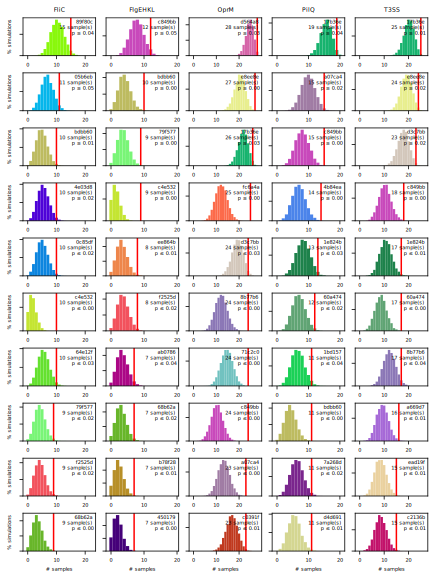

In [9]:
_df_bin = nbselect.compare_binary_phenotypes(
    sel_fts['sig'], phenotypes=['FliC','FlgEHKL','OprM','PilQ','T3SS'], 
    # pos_query=pos_query,
    # neg_query=neg_query,
    # plot=False, 
    plot=True,  
    plot_sparkline=False,
    n_boots=10000,
    subplot_size=(1.2,0.8)
)
_df_bin['nlogp'] = -np.log10(_df_bin['p_value'])

In [10]:
_df_bin['color']='#'+_df_bin['CDR3ID'].str.slice(0,6)

_df_bin_head_1 = _df_bin.sort_values(['phenotype','f_samples'], ascending=False).groupby('phenotype').head(500)
_df_bin_head_2 = _df_bin.sort_values(['phenotype','nlogp'], ascending=False).groupby('phenotype').head(500)
_df_bin_head = pd.concat([_df_bin_head_1, _df_bin_head_2])
_df_bin_head = _df_bin_head[~_df_bin_head.index.duplicated(keep='first')] 

(_df_bin_head[['phenotype','CDR3ID','nlogp','f_samples']]
 .rename(columns={
     'phenotype':'antigen',
     'nlogp':'-log10(binary enrichment probability', 
     'f_samples':'VHH enriched in %samples'})
 .to_csv('results/tables/figures/suppl-hts-metrics.csv')
)

In [11]:
(alt.Chart(_df_bin_head)
 .mark_point(
     # color='#777', strokeWidth=1,
     strokeWidth=0,
     opacity=1.0, 
     size=20,
 )
 .encode(
     x=alt.X(
         'f_samples_pos_sig_jitter:Q',
         title='VHH enriched in %samples', axis=alt.Axis(format='%')),
     y=alt.Y(
         'binary_nlogp_jitter:Q', 
         title='-log10(binary p-value)'
     ),
     fill=alt.Fill('color',scale=None))
 
 .transform_calculate(
    f_samples_pos_sig_jitter="datum.f_samples+0.02*random()",
    binary_nlogp_jitter="datum.nlogp+0.1*random()"
 )
 .properties(width=100, height=100)
 .facet(column='phenotype')
 .configure(
     facet=dict(
        spacing=FONT_SIZE//2
     ),
     point=dict(
         size=FONT_SIZE*3,
         strokeWidth=2,
     ),
     header=dict(
         labelFontSize=FONT_SIZE,
         titleFontSize=FONT_SIZE,
         labelPadding=FONT_SIZE//2,
         titlePadding=0,
     ),
     axis=dict(
         labelFontSize=FONT_SIZE,
         titleFontSize=FONT_SIZE
     ),
     legend=dict(
         titleFontSize=FONT_SIZE,
         labelFontSize=FONT_SIZE,
         symbolSize=FONT_SIZE*2,
         padding=-FONT_SIZE
     )
 )
)

alt.FacetChart(...)